In [480]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt
import numpy as np

import random

In [481]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [482]:
# ==============================
# Preparing the dataset
# ==============================

In [483]:
#generating data
data_1 = np.array([random.choice(range(1000)) for _ in range(10000)])
data_2 = np.array([random.choice(range(1000)) for _ in range(10000)])
X = np.hstack([data_1.reshape(-1,1), data_2.reshape(-1,1)])
Y = data_1 + data_2
Y = Y.reshape(-1, 1) #reshaping is necessary for convergence!

In [484]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.x = torch.tensor(X,dtype=torch.float32)
        self.y = torch.tensor(Y,dtype=torch.float32)
        self.len = self.x.shape[0]

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [485]:
train_dataset = Dataset(X[:8000,:], Y[:8000])
test_dataset = Dataset(X[8000:,:], Y[8000:])

In [486]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

In [487]:
# ==============================
# Defining the dense NN
# ==============================

In [488]:
class DenseNN(nn.Module):
    def __init__(self):
        super(DenseNN, self).__init__()
        self.fc1 = nn.Linear(2, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [489]:
model = DenseNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.00004)
summary(model, input_size=(1, 2), device = device)

Layer (type:depth-idx)                   Output Shape              Param #
DenseNN                                  [1, 1]                    --
├─Linear: 1-1                            [1, 64]                   192
├─Linear: 1-2                            [1, 64]                   4,160
├─Linear: 1-3                            [1, 1]                    65
Total params: 4,417
Trainable params: 4,417
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02

In [490]:
epochs = 100
train_losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.5f}")

Epoch 1/100, Loss: 866600.07200
Epoch 2/100, Loss: 375800.26687
Epoch 3/100, Loss: 93766.14890
Epoch 4/100, Loss: 15108.75232
Epoch 5/100, Loss: 4670.92971
Epoch 6/100, Loss: 2848.38178
Epoch 7/100, Loss: 1716.29221
Epoch 8/100, Loss: 1061.95482
Epoch 9/100, Loss: 690.43880
Epoch 10/100, Loss: 454.39254
Epoch 11/100, Loss: 295.26134
Epoch 12/100, Loss: 186.64087
Epoch 13/100, Loss: 113.48953
Epoch 14/100, Loss: 64.85484
Epoch 15/100, Loss: 34.90320
Epoch 16/100, Loss: 20.13382
Epoch 17/100, Loss: 12.48222
Epoch 18/100, Loss: 7.57325
Epoch 19/100, Loss: 4.53969
Epoch 20/100, Loss: 2.78245
Epoch 21/100, Loss: 1.79977
Epoch 22/100, Loss: 1.26805
Epoch 23/100, Loss: 0.97537
Epoch 24/100, Loss: 0.80574
Epoch 25/100, Loss: 0.70177
Epoch 26/100, Loss: 0.63201
Epoch 27/100, Loss: 0.58182
Epoch 28/100, Loss: 0.54308
Epoch 29/100, Loss: 0.51301
Epoch 30/100, Loss: 0.48527
Epoch 31/100, Loss: 0.46095
Epoch 32/100, Loss: 0.43717
Epoch 33/100, Loss: 0.41880
Epoch 34/100, Loss: 0.39782
Epoch 35/100,

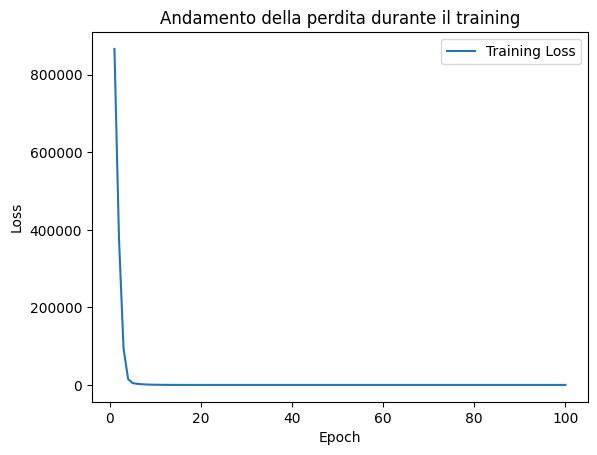

In [510]:
plt.plot(range(1, epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Andamento della perdita durante il training')
plt.legend()
plt.savefig('relazione/immagini/training_loss.png', dpi = 300)

In [492]:
model.eval()
correct = 0
total = 0
tolerance = 0.5
errors = []
total_loss = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        total += labels.size(0)
        
        predicted = outputs.cpu().numpy()
        expected = labels.cpu().numpy()
        
        #calculating training loss
        loss = criterion(outputs, labels)
        total_loss += loss.item() * inputs.size(0)
        
                
        for i in range(inputs.size(0)):
            if np.abs(predicted[i] - expected[i])  <= tolerance:
                correct += 1
            else:
                 errors.append([predicted[i],expected[i]])
                
        
accuracy = 100 * correct / total
print(f'Accuracy sul test set: {accuracy:.2f}%')
print(f'{correct} out of {total}')
print(f'loss totale: {total_loss}')

Accuracy sul test set: 100.00%
2000 out of 2000
loss totale: 34.40687417984009


In [493]:
errors

[]

punto **(f)**

In [494]:

new_inputs = np.array([[5, 7], [100, 200], [400, 200],
[999, 999]])
new_lables = np.array([[12], [300], [600], [1998]])
new_test_loader = DataLoader(Dataset(new_inputs, new_lables),  batch_size=128, shuffle=False)

model.eval()
correct = 0
total = 0
tolerance = 0.5
errors = []

with torch.no_grad():
    for inputs, labels in new_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        total += labels.size(0)
        
        print(outputs)
        print(labels)
        
        for i in range(inputs.size(0)):
            if torch.abs(outputs[i][0] - labels.view(-1, 1)[i])  <= tolerance:
                correct += 1
            else:
                 errors.append([outputs[i][0],labels.view(-1, 1)[i]])
                
        
accuracy = 100 * correct / total
print(f'Accuracy sul test set: {accuracy:.2f}%')
print(f'{correct} out of {total}')

tensor([[  11.9912],
        [ 299.9858],
        [ 599.9171],
        [1997.7350]], device='mps:0')
tensor([[  12.],
        [ 300.],
        [ 600.],
        [1998.]], device='mps:0')
Accuracy sul test set: 100.00%
4 out of 4
